# Project 2: Sales Performance Analysis

In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
# Step 1: Load Dataset
df = pd.read_csv("sales_data.csv", encoding='ISO-8859-1')  # Adjust path if needed
print(df.head())

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   Sout

In [3]:
# Step 2: Initial Inspection
print("Shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
print("Data types:\n", df.dtypes)

Shape: (9994, 21)
Missing values:
 Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64
Data types:
 Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object


In [4]:
# Step 3: Data Cleaning
df.drop_duplicates(inplace=True)

# Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
print(df[['Order Date']].head())

# Remove currency symbols and convert to numeric
columns_to_clean = ['Sales', 'Profit', 'Discount']
for col in columns_to_clean:
    df[col] = df[col].replace('[$,₹]', '', regex=True).astype(float)


  Order Date
0 2016-11-08
1 2016-11-08
2 2016-06-12
3 2015-10-11
4 2015-10-11


In [5]:
# Remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

for col in ['Sales', 'Profit', 'Discount']:
    df = remove_outliers(df, col)

# Describe numeric features
print(df.describe())


            Row ID                     Order Date   Postal Code        Sales  \
count  6779.000000                           6779   6779.000000  6779.000000   
mean   4998.562030  2016-05-02 05:21:36.297388800  55814.501991    67.004453   
min       1.000000            2014-01-03 00:00:00   1453.000000     0.990000   
25%    2514.500000            2015-05-25 00:00:00  22304.000000    14.940000   
50%    5022.000000            2016-07-04 00:00:00  56560.000000    34.790000   
75%    7464.500000            2017-05-18 00:00:00  90036.000000    82.600000   
max    9993.000000            2017-12-30 00:00:00  99301.000000   496.860000   
std    2878.409888                            NaN  32815.156873    84.303233   

          Quantity     Discount       Profit  
count  6779.000000  6779.000000  6779.000000  
mean      3.453607     0.097199    11.327627  
min       1.000000     0.000000   -27.715800  
25%       2.000000     0.000000     3.235200  
50%       3.000000     0.000000     7.921200

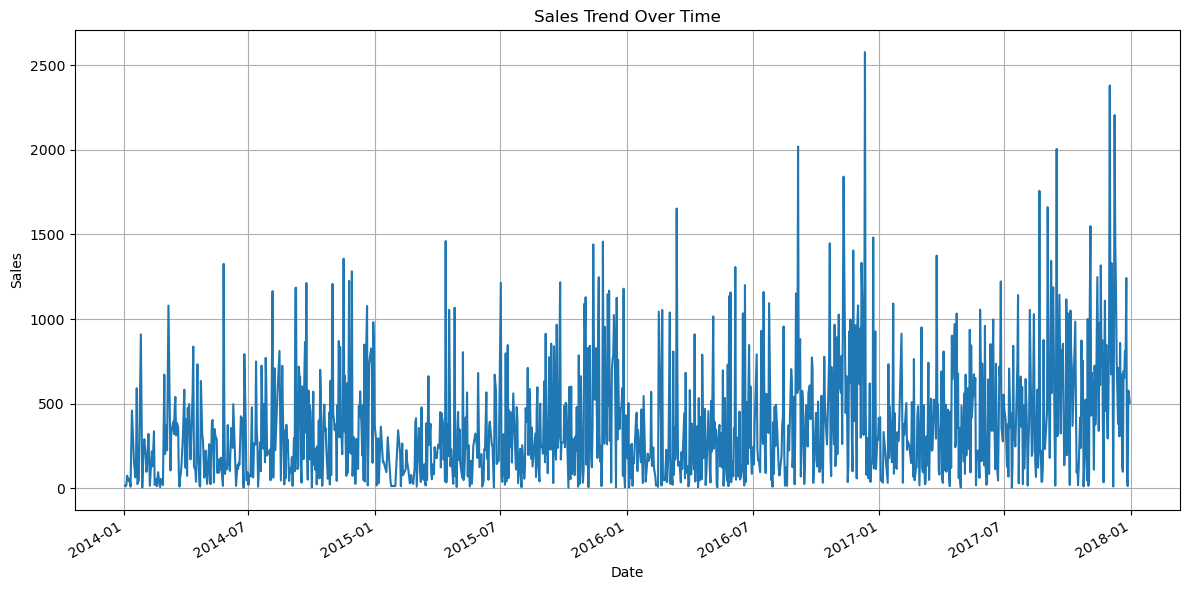

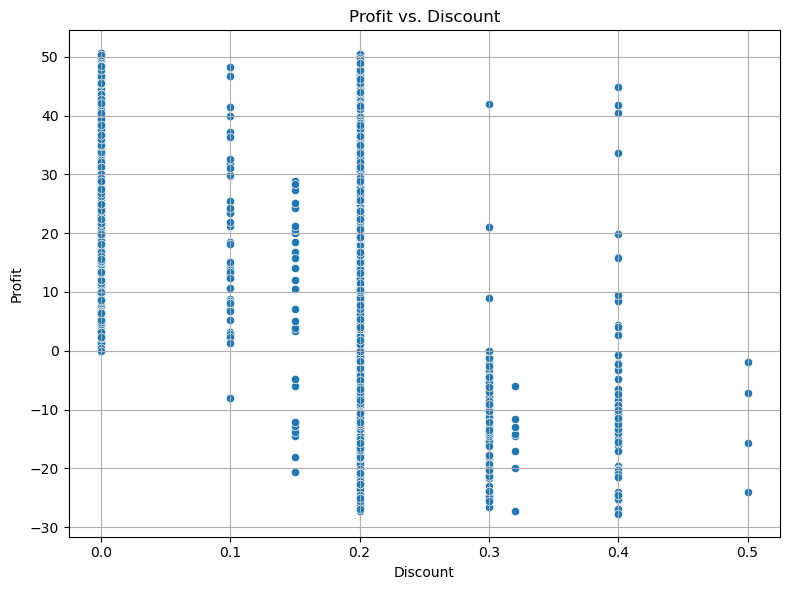

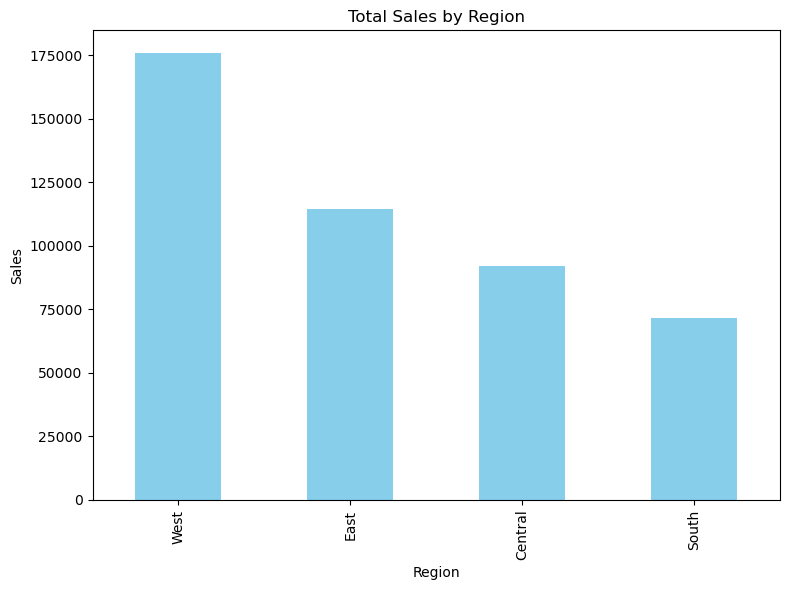

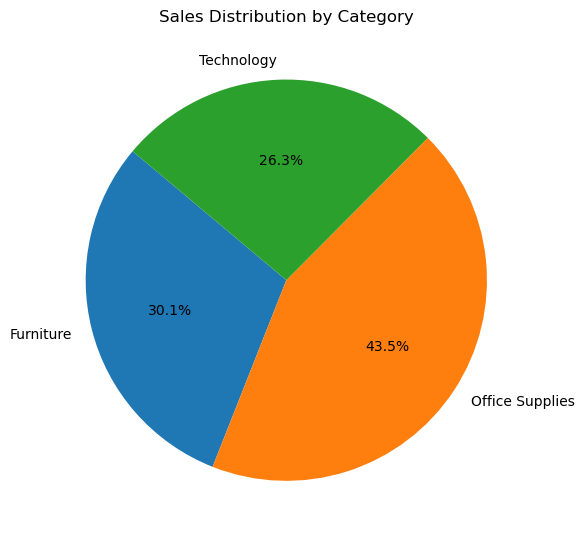

In [6]:
# Step 4: Exploratory Data Analysis

# 4.1 Time Series Plot of Sales
sales_trend = df.groupby('Order Date')['Sales'].sum()
plt.figure(figsize=(12,6))
sales_trend.plot()
plt.title("Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4.2 Scatter Plot: Profit vs. Discount
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Discount', y='Profit')
plt.title("Profit vs. Discount")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4.3 Bar Plot: Sales by Region
region_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)
region_sales.plot(kind='bar', figsize=(8,6), color='skyblue')
plt.title("Total Sales by Region")
plt.ylabel("Sales")
plt.xlabel("Region")
plt.tight_layout()
plt.show()

# 4.4 Pie Chart: Sales by Category
category_sales = df.groupby('Category')['Sales'].sum()
category_sales.plot(kind='pie', autopct='%1.1f%%', figsize=(6,6), startangle=140)
plt.title("Sales Distribution by Category")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [7]:
# Checking Correlation between Profit, Sales and Discount
print(df[['Sales', 'Profit', 'Discount']].corr())

             Sales    Profit  Discount
Sales     1.000000  0.367258  0.149816
Profit    0.367258  1.000000 -0.281663
Discount  0.149816 -0.281663  1.000000


In [8]:
# Step 5: Predictive Modeling (Linear Regression)

# Features and Target
X = df[['Profit','Discount']]
y = df['Sales']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)


print("\nModel Evaluation:")
print("R² Score:", round(r2, 4))
print("Mean Squared Error:", round(mse, 2))



Model Evaluation:
R² Score: 0.1869
Mean Squared Error: 6473.32


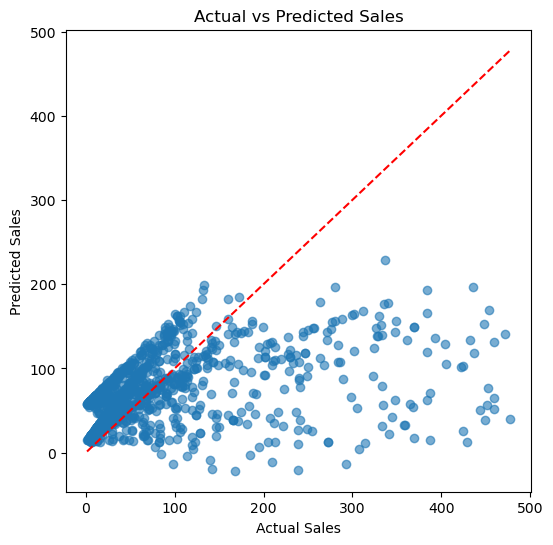

In [9]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.show()


# Linear regression was implemented as required, but its poor performance (R² = 0.18)highlights the need for additional or more relevant features. A better-performing model may require nonlinear algorithms as the dataset is too big to handle with some details missing to predict turns into inaccuracy.